# Exploratory Data Analysis

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
%matplotlib inline

In [29]:
df = pd.read_csv('./data/clean.csv', index_col='Unnamed: 0')

In [30]:
df.head()

,author,anxiety,title,selftext,created_utc,retrieved_on,url,pinned,media_only,adhd
0,ZorroNegro,1.0,"Please, I need help",My friend asked me to be his best man for his ...,1554340190,1554340191,https://www.reddit.com/r/Anxiety/comments/b96c...,False,False,0.0
1,PupperinoSuprimo,1.0,"If you'll never really know, let that damn tho...","Lately, this has become a sort of mantra Ive s...",1554338785,1554338785,https://www.reddit.com/r/Anxiety/comments/b964...,False,False,0.0
2,moake740,1.0,Feeling like such a failure,"I suck, I haven’t been taking my meds a prescr...",1554338572,1554338573,https://www.reddit.com/r/Anxiety/comments/b963...,False,False,0.0
3,ketchuptiles,1.0,Rolling anxiety attacks?,"Hey everyone, I could really use your collect...",1554338312,1554338313,https://www.reddit.com/r/Anxiety/comments/b961...,False,False,0.0
5,SageLukahn,1.0,Why I don't try new things.,I am on a diet (keto). It is not a particularl...,1554337837,1554337838,https://www.reddit.com/r/Anxiety/comments/b95y...,False,False,0.0


Creating columns for word and character counts for the subreddit posts

In [31]:
df['char_count'] = df.selftext.map(len)

In [32]:
df['word_count'] = df.selftext.map(lambda x: len(x.split()))

In [33]:
df.char_count.groupby(df.adhd).mean()

adhd
0.0    966.108905
1.0    890.806593
Name: char_count, dtype: float64

In [34]:
df.word_count.groupby(df.adhd).mean()

adhd
0.0    184.699376
1.0    165.465385
Name: word_count, dtype: float64

As we can see, the average word and character counts for posts is higher for the Anxiety subreddit, 185 and 966, respectively. Below are some visualizations of these distributions. 

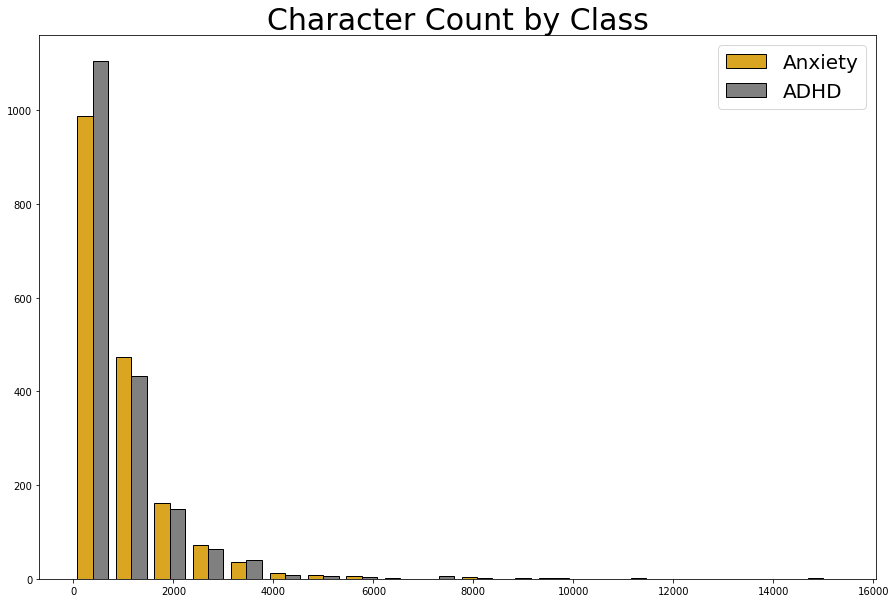

In [35]:
plt.figure(figsize=(15,10))
plt.hist([df[df['adhd']==0]['char_count'], 
          df[df['adhd']==1]['char_count']],
         bins=20, color=['goldenrod', 'grey'], ec='k')
plt.title('Character Count by Class', fontsize=30)
plt.legend(['Anxiety', 'ADHD'], fontsize=20)

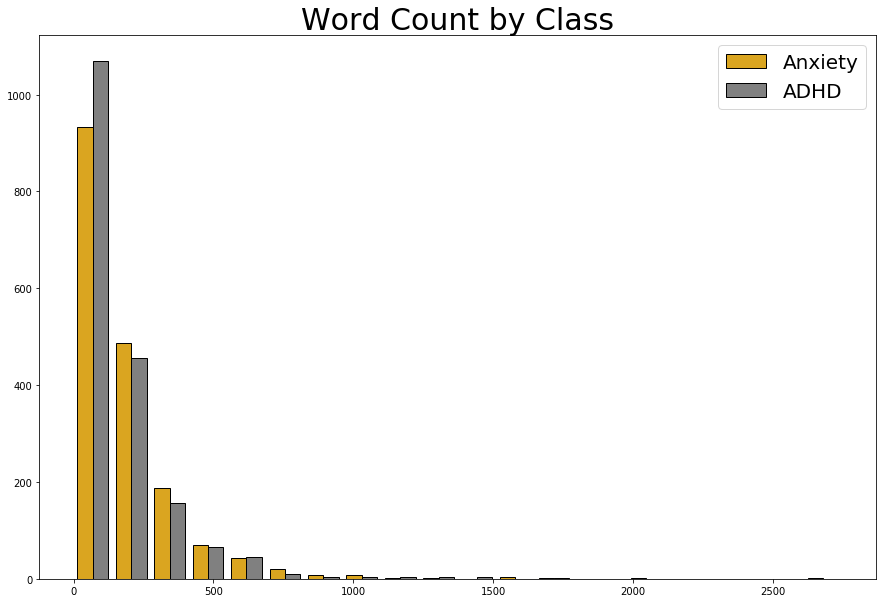

In [155]:
plt.figure(figsize=(15,10))
plt.hist([df[df['adhd']==0]['word_count'], 
          df[df['adhd']==1]['word_count']],
         bins=20, color=['goldenrod', 'grey'], ec='k')
plt.title('Word Count by Class', fontsize=30)
plt.legend(['Anxiety', 'ADHD'], fontsize=20)
plt.savefig('./assets/wordcount.png')

As is expected, the vast majority of posts in both subreddits are very short, with very few posts having over 1000 words (hence the long right tails of the distributions). 

---

Now we'll move on to more advanced natural language processing (NLP). Before that, however, I am going to add some custom stop_words that aren't included in the default Sklearn library. Stop words are very common words that do not convey much meaning, which we explicitly tell our models to ignore.

In [139]:
custom_words = frozenset(['just', 'like', 'im', 'ive', 've', 'really', 'dont', 'don'])

In [140]:
stopwords = ENGLISH_STOP_WORDS.union(custom_words)

Using CountVectorizer for all posts, which takes all the words in the posts and creates columns of them containing the word's prevalence (i.e. frequency count). 

In [141]:
cvec = CountVectorizer(stop_words=stopwords, min_df=5, max_df=1.0)

I set the minimum document frequency to be 5 (i.e. words must be in at least 5 documents to be included). Setting the max_df to 1.0 means that no words will be left out because they are too common (but hopefully using the custom stop words will eliminate some of the noise).

In [142]:
term_matrix = cvec.fit_transform(df['selftext'])

In [143]:
len(cvec.get_feature_names())

4645

After all the cleaning and excluding stop words, we are left with over 4600 words. 

In [144]:
term_df = pd.DataFrame(term_matrix.toarray(), columns=cvec.get_feature_names())

Putting the ADHD column back into the dataframe.

In [145]:
term_df.insert(0, 'ADHD', df.adhd)

In [146]:
term_df.head()

,ADHD,00,000,03,10,100,1000,100mg,10mg,10th,...,youtu,youtube,youve,yr,zero,zoloft,zombie,zone,zoned,zoning
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now looking at a snapshot of distributions for the words between the ADHD and Anxiety subreddits.

In [147]:
term_df.groupby('ADHD').mean()

,00,000,03,10,100,1000,100mg,10mg,10th,10x,...,youtu,youtube,youve,yr,zero,zoloft,zombie,zone,zoned,zoning
ADHD,,,,,,,,,,,,,,,,,,,,,
0.0,0.004538,0.002836,0.003403,0.041974,0.028361,0.001702,0.003403,0.009643,0.000567,0.001702,...,0.003403,0.010210,0.009643,0.003403,0.005105,0.017016,0.003971,0.015315,0.000567,0.000000
1.0,0.006250,0.002778,0.004167,0.084028,0.021528,0.000694,0.001389,0.027083,0.003472,0.002083,...,0.004167,0.026389,0.009028,0.000694,0.005556,0.004167,0.011806,0.008333,0.002083,0.003472


In [148]:
term_df.groupby('ADHD').sum()

,00,000,03,10,100,1000,100mg,10mg,10th,10x,...,youtu,youtube,youve,yr,zero,zoloft,zombie,zone,zoned,zoning
ADHD,,,,,,,,,,,,,,,,,,,,,
0.0,8,5,6,74,50,3,6,17,1,3,...,6,18,17,6,9,30,7,27,1,0
1.0,9,4,6,121,31,1,2,39,5,3,...,6,38,13,1,8,6,17,12,3,5


The above outputs are not easy on the eyes, but by transposing them and sorting by one of our groups, we can more easily see what are the most used words.

In [154]:
term_df.groupby('ADHD').mean().T.sort_values(1, ascending=False).head(20)

ADHD,0.0,1.0
time,0.639251,0.607639
feel,0.918321,0.552083
know,0.702212,0.538194
work,0.395916,0.444444
things,0.364152,0.419444
day,0.374362,0.376389
want,0.483834,0.323611
life,0.375496,0.318056
people,0.462280,0.305556
going,0.448100,0.276389


In [150]:
term_df.groupby('ADHD').sum().T.sort_values(1, ascending=False).head(20)

ADHD,0.0,1.0
time,1127,875
feel,1619,795
know,1238,775
work,698,640
things,642,604
day,660,542
want,853,466
life,662,458
people,815,440
going,790,398


It's no surprise that the most frequently used word is 'time,' since time management is one of the biggest struggles for those with ADHD. It seems as though there may be quite a bit of overlap, but let's grab the top 20 terms in each subreddit and systematically look at the overlapping words.

In [151]:
top_words_anxiety = list(term_df.groupby('ADHD').mean().T.sort_values(0, ascending=False).head(20).index)

top_words_adhd = list(term_df.groupby('ADHD').mean().T.sort_values(1, ascending=False).head(20).index)

In [152]:
top_words_overlap = [word for word in top_words_adhd if word in top_words_anxiety]

In [153]:
top_words_overlap

['time',
 'feel',
 'know',
 'work',
 'things',
 'day',
 'want',
 'life',
 'people',
 'going',
 'got',
 'think',
 'need',
 'help']

We can see that 14 out of the top 20 words for each subreddit overlap with one another, which lends credence to my problem statement and the issues regarding misdiagnosis. In my next notebook, I'll be diving into some more advanced modeling with logistic regression and random forests.